**OBJECTIVE: EDA ON AUDIO FEATURES EXTRACTED FROM YOUTUBE PERVIEWS**

The notebook takes data extracted using the yt-dlp based pipeline and processed using librosa. Audio features were calculated on audio previews such as tempo, rms_mean, MFCCs,etc. They were used to approximate audio characteristics.


| Feature                    | What it approximates / represents                                                                                                     |
| -------------------------- | ------------------------------------------------------------------------------------------------------------------------------------- |
| **tempo**                  | The speed or pace of the track (beats per minute, BPM). Higher tempo → faster rhythm.                                                 |
| **rms_mean**               | The average Root Mean Square energy; a measure of loudness or overall signal intensity.                                               |
| **spectral_centroid_mean** | The “center of mass” of the spectrum; correlates with the perceived brightness of the sound. Higher values → brighter/sharper timbre. |
| **zcr_mean**               | Zero-Crossing Rate; approximates noisiness or percussiveness of the signal. High ZCR → more noise or sharp transient content.         |
| **mfcc_1_mean**            | Mel-Frequency Cepstral Coefficient 1; roughly captures overall spectral shape, often correlates with timbral envelope.                |
| **mfcc_2_mean**            | MFCC 2; captures more detailed spectral texture, often related to pitch content and timbre nuances.                                   |
| **mfcc_3_mean**            | MFCC 3; more fine-grained spectral characteristics, can reflect harmonic content.                                                     |
| **mfcc_4_mean**            | MFCC 4; higher-order spectral variations, subtle timbre details.                                                                      |
| **mfcc_5_mean**            | MFCC 5; continues to approximate fine timbre and tonal quality.                                                                       |



EDA was done on this extraction data using distribution plots, sequencing,variability and PCA to estimate cohesion.


In [17]:
import pandas as pd

df1 = pd.read_csv("/content/audio_features_filtered_tracks.csv")
df2 = pd.read_csv("/content/audio_features_full.csv")

df = (
    pd.concat([df1, df2], ignore_index=True)
      .drop_duplicates(subset=["track_uri", "track_name", "artist_name"])
)

df.head()


(3300, 21)


,pid,track_uri,track_name,artist_uri,artist_name,album_uri,album_name,duration_ms,position,popularity_bucket,...,tempo,rms_mean,spectral_centroid_mean,zcr_mean,mfcc_1_mean,mfcc_2_mean,mfcc_3_mean,mfcc_4_mean,mfcc_5_mean,features
0,139592,spotify:track:3dXjAh7UEuCJnLIeFKNkxd,Throw Shade,spotify:artist:1jNnM5dm7dzt16IocWCvJc,CRUISR,spotify:album:2As7VxUbc9rvhYxFjLMMtX,Throw Shade,172986,0,moderate,...,107.666016,0.233692,2687.641530,0.111042,-48.803425,74.834091,-2.578117,11.085922,4.693387,NaN
1,139592,spotify:track:6F609ICg9Spjrw1epsAnpa,Controlla,spotify:artist:3TVXtAsR1Inumwj472S9r4,Drake,spotify:album:3hARKC8cinq3mZLLAEaBh9,Views,245226,2,moderate,...,123.046875,0.166129,2784.702110,0.126189,-157.355789,66.958809,17.003344,8.415695,-5.050884,NaN
2,139592,spotify:track:6QXAMI7XJf2n2dO4RUhOde,Sunshine,spotify:artist:0PGB0xsAyDqHHlvNQcgq5S,POWERS,spotify:album:259fprFM35HqQLjnsrZNVY,Sunshine,254640,5,moderate,...,117.453835,0.235486,2233.951885,0.085048,-80.818367,92.007225,-2.668023,12.538932,-4.548662,NaN
3,139592,spotify:track:4eXwZEaNP8LIsr8GwhbIrV,Red Dress,spotify:artist:0DxeaLnv6SyYk2DOqkLO8c,MAGIC!,spotify:album:7vY2gUm5FfFjUHz3DvCaD3,Primary Colours,200800,8,moderate,...,135.999178,0.257934,2450.323896,0.103743,-38.007507,82.621124,-11.243086,20.687113,4.782074,NaN
4,139592,spotify:track:50jpXOEY8k6YZRhhAt8YYC,Never Enough,spotify:artist:7jZycSvTyx0W9poD4PjEIG,The Hunna,spotify:album:2NauBynslhNjePGjGcN202,100,173600,9,moderate,...,103.359375,0.243295,2406.930553,0.116564,-41.304398,83.013550,-18.406643,32.605942,8.754118,NaN


#**Reading playlist metadata, to use categorization on the basis of popularity**

In [18]:
playlists=pd.read_csv("/content/playlists.csv")

In [19]:
#adding metric for popularity (1M playlist csv)

def popularity_bucket(n):
    if n >= 100_000:
        return 'viral / editorial'
    elif n >= 10_000:
        return 'very popular'
    elif n >= 1_000:
        return 'popular'
    elif n >= 100:
        return 'moderate'
    else:
        return 'niche / personal'

playlists['popularity_bucket'] = (
    playlists['num_followers']
    .fillna(0)
    .apply(popularity_bucket)
)

In [20]:
# keep only what we need from playlists
pop_map = playlists[['pid', 'popularity_bucket']]

# merge into df
df = df.merge(
    pop_map,
    on='pid',
    how='left',
    suffixes=('', '_from_playlists')
)

# fill missing values in df.popularity_bucket
df['popularity_bucket'] = (
    df['popularity_bucket']
    .fillna(df['popularity_bucket_from_playlists'])
)

# drop helper column
df = df.drop(columns=['popularity_bucket_from_playlists'])


**Z-score base features**

In [21]:
from sklearn.preprocessing import StandardScaler

BASE_FEATURES = [
    "rms_mean",
    "zcr_mean",
    "spectral_centroid_mean",
    "mfcc_1_mean",
    "tempo"
]

scaler = StandardScaler()
df[[f"{c}_z" for c in BASE_FEATURES]] = scaler.fit_transform(df[BASE_FEATURES])


**Construct perceptual features**

In [22]:
# Energy / intensity
df["energy_intensity"] = (
    0.6 * df["rms_mean_z"] +
    0.4 * df["zcr_mean_z"]
)

# Brightness
df["brightness"] = (
    0.7 * df["spectral_centroid_mean_z"] +
    0.3 * df["mfcc_1_mean_z"]
)

# Rhythm (keep tempo as-is, already normalized)
df["rhythm"] = df["tempo_z"]

# Timbre complexity (MFCC variance across coefficients)
MFCC_COLS = [f"mfcc_{i}_mean" for i in range(1, 6)]
df["timbre_complexity"] = df[MFCC_COLS].std(axis=1)


In [23]:
FINAL_FEATURES = [
    "energy_intensity",
    "brightness",
    "rhythm",
    "timbre_complexity"
]

df[[f"{c}_z" for c in FINAL_FEATURES]] = scaler.fit_transform(df[FINAL_FEATURES])


# **Distributional plots**

In [24]:
curation_palette = {
    "niche / personal": "#3C5030",   # deep teal → intimate, user-curated
    "moderate": "#73836A",           # growing but still organic
    "popular": "#E0C1C2",            # discovery sweet spot
    "very popular": "#D09497",       # neutral / algorithmic balance
    "viral / editorial": "#aba88c"   # platform-driven, high exposure
}

**Tempo distribution**

/tmp/ipython-input-4115501291.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


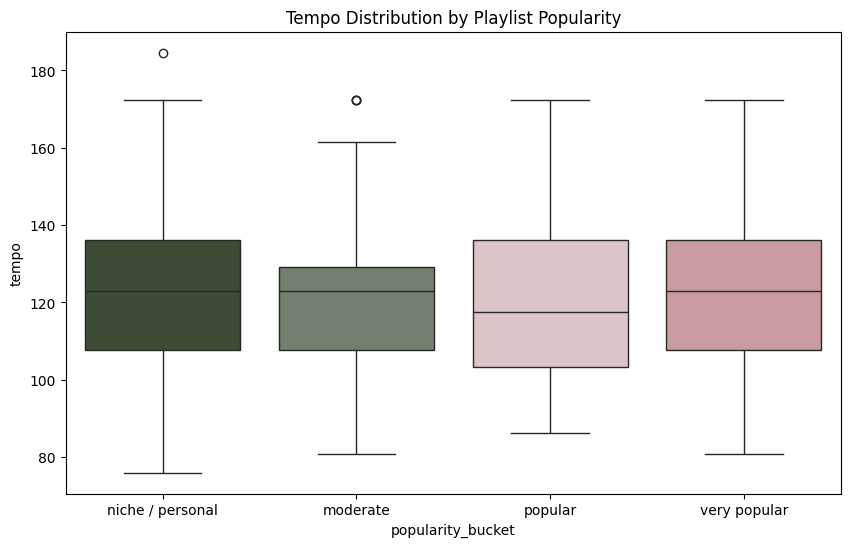

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.boxplot(
    data=df,
    x="popularity_bucket",
    y="tempo",
    palette=curation_palette,
    order=["niche / personal", "moderate", "popular", "very popular"]
)
plt.title("Tempo Distribution by Playlist Popularity")
plt.show()


**Energy (composite)**

/tmp/ipython-input-188002332.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(


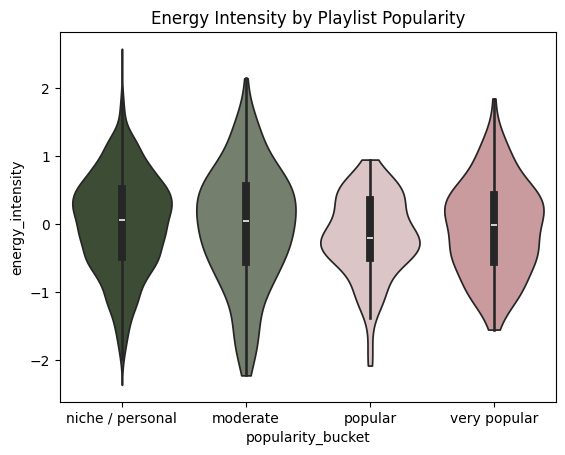

In [26]:
sns.violinplot(
    data=df,
    x="popularity_bucket",
    y="energy_intensity",
    cut=0,
    palette=curation_palette,
    order=["niche / personal", "moderate", "popular", "very popular"]
)
plt.title("Energy Intensity by Playlist Popularity")
plt.show()


**Brightness**

/tmp/ipython-input-1129513207.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


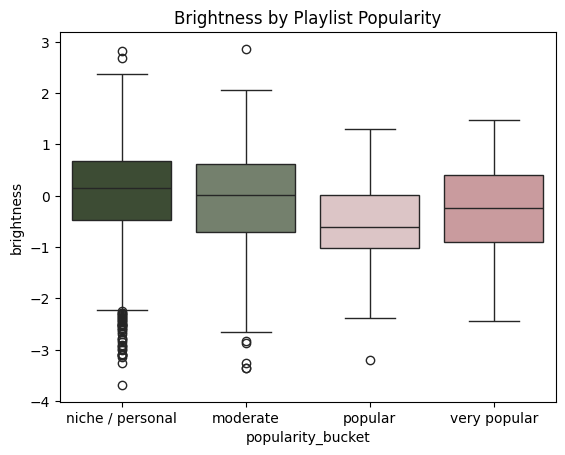

In [27]:
sns.boxplot(
    data=df,
    x="popularity_bucket",
    y="brightness",
    palette=curation_palette,
    order=["niche / personal", "moderate", "popular", "very popular"]
)
plt.title("Brightness by Playlist Popularity")
plt.show()


**MFCC variance (per-playlist)**

/tmp/ipython-input-2520915810.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


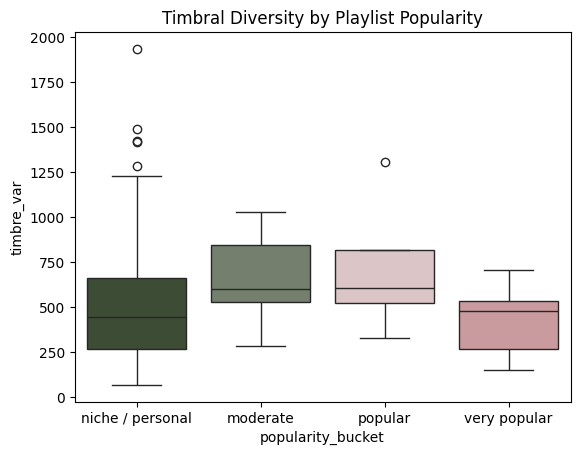

In [28]:
timbre_var = (
    df.groupby(["pid", "popularity_bucket"])
      .agg(timbre_var=("timbre_complexity", "var"))
      .reset_index()
)

sns.boxplot(
    data=timbre_var,
    x="popularity_bucket",
    y="timbre_var",
    palette=curation_palette,
    order=["niche / personal", "moderate", "popular", "very popular"]
)
plt.title("Timbral Diversity by Playlist Popularity")
plt.show()


**Sequencing dynamics**

In [29]:
df["pos_norm"] = df.groupby("pid")["position"].transform(
    lambda x: x / x.max()
)


**Mean tempo trajectory**

In [31]:
df["pos_bin"] = pd.cut(df["pos_norm"], bins=25, labels=False)

In [32]:
import numpy as np
agg_df = (
    df
    .groupby(["popularity_bucket", "pos_bin"])
    .agg(
        mean_tempo=("tempo", "mean"),
        std_tempo=("tempo", "std"),
        n=("tempo", "count")
    )
    .reset_index()
)

agg_df["se_tempo"] = agg_df["std_tempo"] / np.sqrt(agg_df["n"])


In [33]:
agg_df["mean_tempo_smooth"] = (
    agg_df
    .groupby("popularity_bucket")["mean_tempo"]
    .transform(lambda x: x.rolling(3, center=True, min_periods=1).mean())
)


In [34]:
agg_df["mean_tempo_smooth"] = (
    agg_df
    .groupby("popularity_bucket")["mean_tempo"]
    .transform(lambda x: x.rolling(3, center=True, min_periods=1).mean())
)


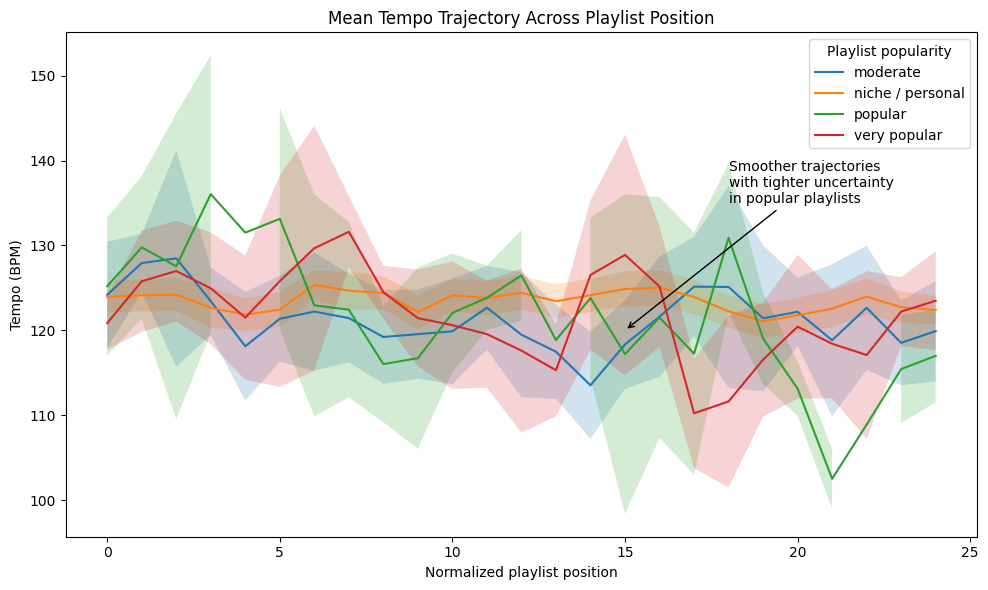

In [35]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

for bucket, g in agg_df.groupby("popularity_bucket"):
    x = g["pos_bin"]
    y = g["mean_tempo_smooth"]

    plt.plot(x, y, label=bucket)
    plt.fill_between(
        x,
        y - g["se_tempo"],
        y + g["se_tempo"],
        alpha=0.2
    )
plt.annotate(
    "Smoother trajectories\nwith tighter uncertainty\nin popular playlists",
    xy=(15, 120),
    xytext=(18, 135),
    arrowprops=dict(arrowstyle="->", lw=1),
    fontsize=10
)

plt.title("Mean Tempo Trajectory Across Playlist Position")
plt.xlabel("Normalized playlist position")
plt.ylabel("Tempo (BPM)")
plt.legend(title="Playlist popularity")
plt.tight_layout()
plt.show()


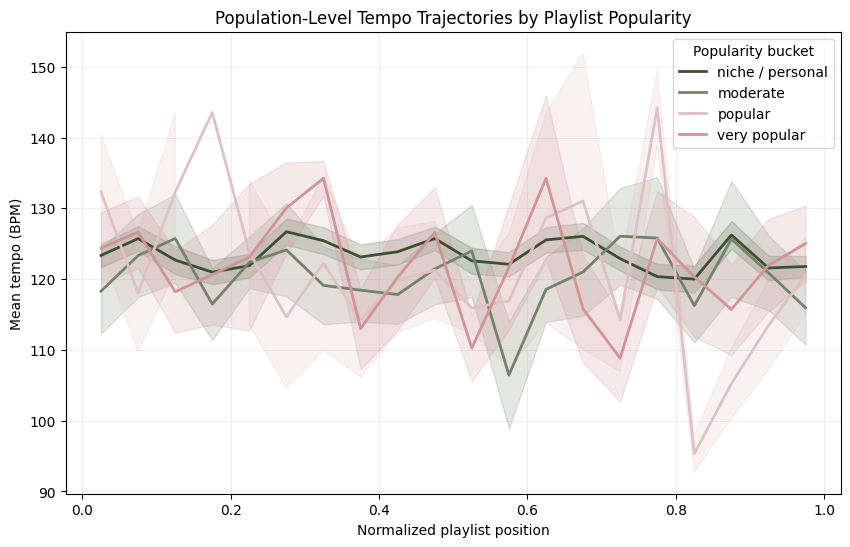

In [62]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 6))

bucket_order = [
    "niche / personal",
    "moderate",
    "popular",
    "very popular"
]

for bucket in bucket_order:
    d = agg[agg["popularity_bucket"] == bucket]

    ax.plot(
        d["pos_center"],
        d["mean_tempo"],
        label=bucket,
        linewidth=2,
        color=curation_palette[bucket]
    )

    ax.fill_between(
        d["pos_center"],
        d["mean_tempo"] - d["sem"],
        d["mean_tempo"] + d["sem"],
        color=curation_palette[bucket],
        alpha=0.2
    )

ax.set_xlabel("Normalized playlist position")
ax.set_ylabel("Mean tempo (BPM)")
ax.set_title("Population-Level Tempo Trajectories by Playlist Popularity")
ax.legend(title="Popularity bucket")
ax.grid(alpha=0.2)

plt.show()


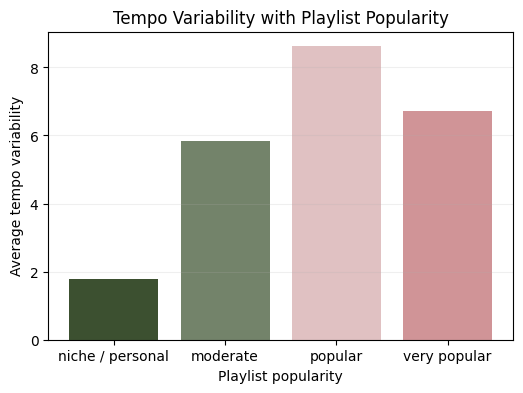

In [64]:
variability = (
    agg
    .groupby("popularity_bucket")
    .agg(mean_sem=("sem", "mean"))
    .reset_index()
)

# enforce order
variability["popularity_bucket"] = pd.Categorical(
    variability["popularity_bucket"],
    categories=bucket_order,
    ordered=True
)

variability = variability.sort_values("popularity_bucket")

plt.figure(figsize=(6, 4))
plt.bar(
    variability["popularity_bucket"],
    variability["mean_sem"],
    color=[curation_palette[b] for b in variability["popularity_bucket"]]
)

plt.ylabel("Average tempo variability")
plt.xlabel("Playlist popularity")
plt.title("Tempo Variability with Playlist Popularity")
plt.grid(axis="y", alpha=0.2)

plt.show()


**Representative playlists**

In [41]:
def plot_playlist(pid):
    g = df[df["pid"] == pid]
    plt.plot(g["pos_norm"], g["tempo"])
    plt.title(f"Tempo Trajectory — Playlist {pid}")
    plt.show()


**Variability vs popularity (unifying plot)**

In [65]:
FEATURE_COLS = {
    "tempo": "tempo",
    "rms": "rms_mean",
    "spectral_centroid": "spectral_centroid_mean",
    "zcr": "zcr_mean",
    "mfcc_1": "mfcc_1_mean",
    "mfcc_2": "mfcc_2_mean"
}

playlist_var = (
    df
    .groupby(["pid", "popularity_bucket"])
    .agg({v: "std" for v in FEATURE_COLS.values()})
    .reset_index()
)


In [66]:
long_var = playlist_var.melt(
    id_vars=["pid", "popularity_bucket"],
    value_vars=list(FEATURE_COLS.values()),
    var_name="feature",
    value_name="within_playlist_std"
)

bucket_var = (
    long_var
    .groupby(["popularity_bucket", "feature"])
    .agg(mean_std=("within_playlist_std", "mean"))
    .reset_index()
)

bucket_var["popularity_bucket"] = pd.Categorical(
    bucket_var["popularity_bucket"],
    categories=[
        "niche / personal",
        "moderate",
        "popular",
        "very popular"
    ],
    ordered=True
)

bucket_var = bucket_var.sort_values("popularity_bucket")


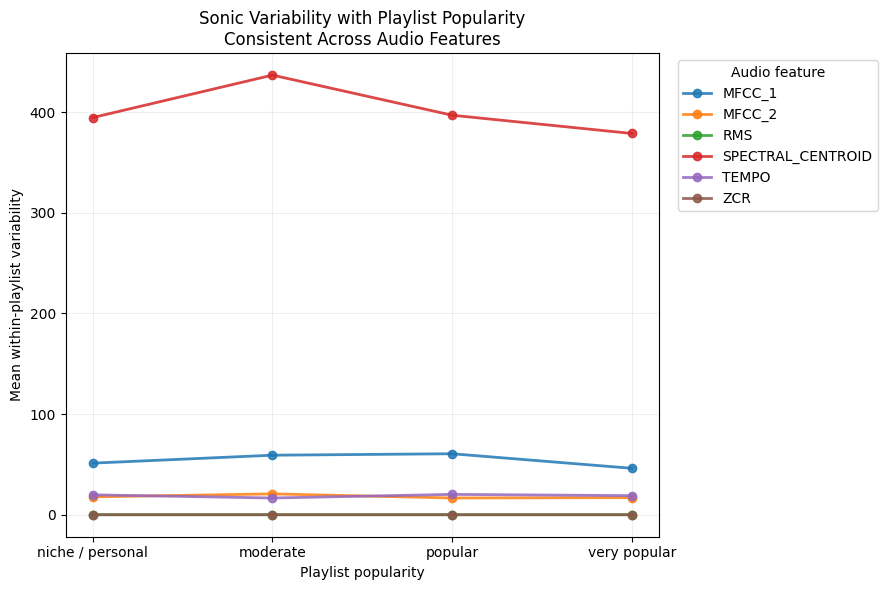

In [73]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(9, 6))

for feature, g in bucket_var.groupby("feature"):
    ax.plot(
        g["popularity_bucket"],
        g["mean_std"],
        marker="o",
        linewidth=2,
        alpha=0.85,
        label=feature.replace("_mean", "").upper()
    )

ax.set_ylabel("Mean within-playlist variability")
ax.set_xlabel("Playlist popularity")
ax.set_title(
    "Sonic Variability with Playlist Popularity\n"
    "Consistent Across Audio Features"
)

ax.grid(alpha=0.2)
ax.legend(title="Audio feature", bbox_to_anchor=(1.02, 1), loc="upper left")

plt.tight_layout()
plt.show()


In [68]:
corrs = (
    bucket_var
    .assign(pop_rank=lambda d: d["popularity_bucket"].cat.codes)
    .groupby("feature")
    .apply(lambda g: g["pop_rank"].corr(g["mean_std"]))
    .reset_index(name="corr_with_popularity")
)

corrs


/tmp/ipython-input-2686963447.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g["pop_rank"].corr(g["mean_std"]))


,feature,corr_with_popularity
0,mfcc_1_mean,-0.264768
1,mfcc_2_mean,-0.445269
2,rms_mean,-0.723285
3,spectral_centroid_mean,-0.455799
4,tempo,0.088001
5,zcr_mean,-0.764299


**PCA (3D) + Euclidean cohesion (one playlist per bucket)**

/tmp/ipython-input-1961470175.py:82: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(add_dist_to_centroid)


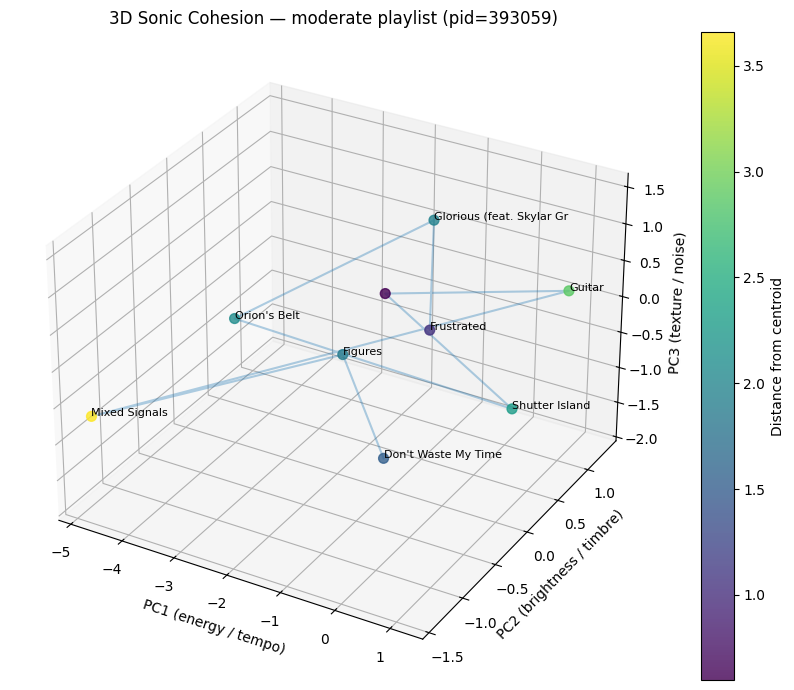

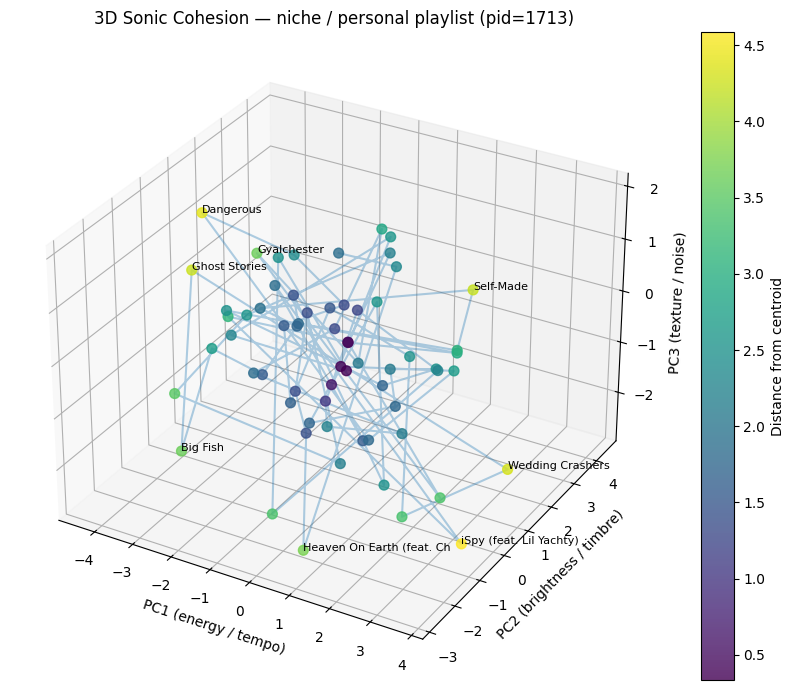

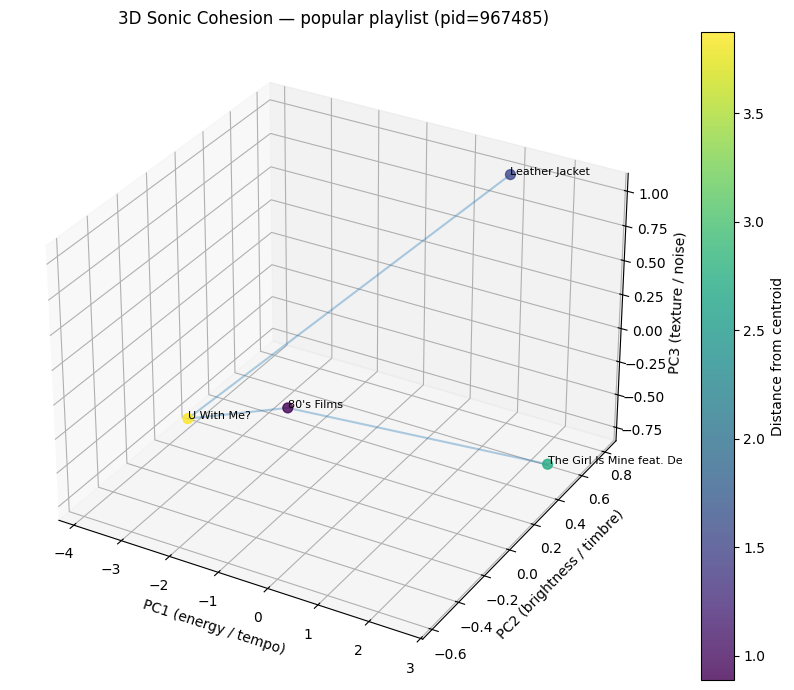

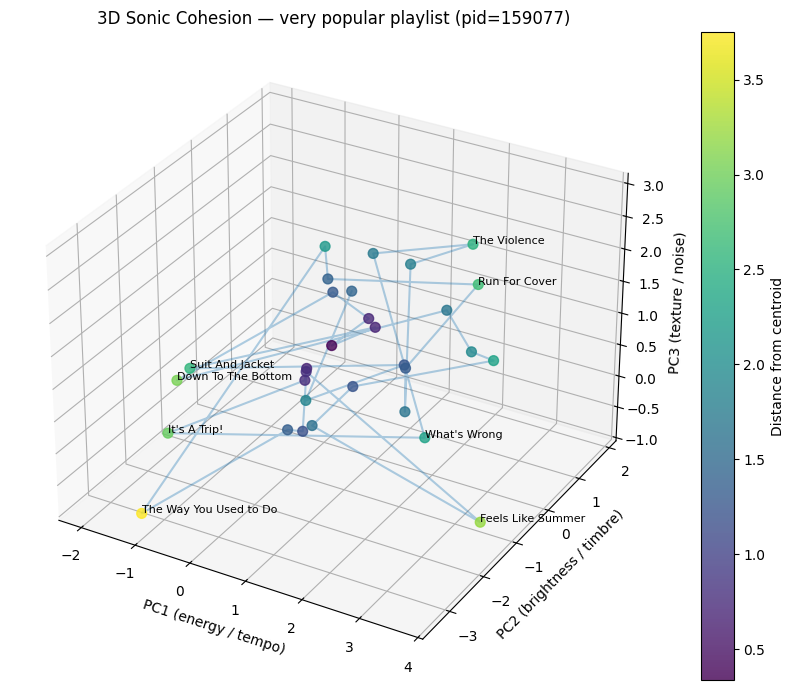

,pid,popularity_bucket,mean_dist
0,1713,niche / personal,2.253240
1,159077,very popular,1.749534
2,393059,moderate,1.992067
3,967485,popular,2.258078


In [43]:
# -----------------------
# 0. Column check
# -----------------------
REQUIRED_COLS = [
    "pid",
    "popularity_bucket",
    "track_name",
    "position",
    "tempo",
    "rms_mean",
    "spectral_centroid_mean",
    "zcr_mean",
    "mfcc_1_mean",
    "mfcc_2_mean",
    "mfcc_3_mean",
    "mfcc_4_mean",
    "mfcc_5_mean"
]

missing = set(REQUIRED_COLS) - set(df.columns)
assert not missing, f"Missing columns: {missing}"

# -----------------------
# 1. Sample ONE playlist per popularity bucket
# -----------------------
sample_pids = (
    df[["pid", "popularity_bucket"]]
    .drop_duplicates()
    .groupby("popularity_bucket", group_keys=False)
    .sample(n=1)
)

viz_df = df.merge(
    sample_pids,
    on=["pid", "popularity_bucket"],
    how="inner"
)

# -----------------------
# 2. Feature prep + PCA (GLOBAL)
# -----------------------
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import numpy as np

FEATURE_COLS = [
    "tempo",
    "rms_mean",
    "spectral_centroid_mean",
    "zcr_mean",
    "mfcc_1_mean",
    "mfcc_2_mean",
    "mfcc_3_mean",
    "mfcc_4_mean",
    "mfcc_5_mean"
]

scaler = StandardScaler()
X = scaler.fit_transform(viz_df[FEATURE_COLS])

pca = PCA(n_components=3, random_state=42)
pcs = pca.fit_transform(X)

viz_df[["pc1", "pc2", "pc3"]] = pcs

# -----------------------
# 3. Distance to centroid (playlist cohesion)
# -----------------------
def add_dist_to_centroid(g):
    centroid = g[["pc1", "pc2", "pc3"]].mean().values
    dists = np.linalg.norm(
        g[["pc1", "pc2", "pc3"]].values - centroid,
        axis=1
    )
    g = g.copy()
    g["dist_to_centroid"] = dists
    return g

viz_df = (
    viz_df
    .groupby("pid", group_keys=False)
    .apply(add_dist_to_centroid)
)

# -----------------------
# 4. 3D Visualization
# -----------------------
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def plot_playlist_3d(df, pid):
    g = (
        df[df["pid"] == pid]
        .sort_values("position")
        .reset_index(drop=True)
    )

    fig = plt.figure(figsize=(9, 7))
    ax = fig.add_subplot(111, projection="3d")

    sc = ax.scatter(
        g["pc1"],
        g["pc2"],
        g["pc3"],
        c=g["dist_to_centroid"],
        s=50,
        alpha=0.8
    )

    # sequencing path
    ax.plot(
        g["pc1"],
        g["pc2"],
        g["pc3"],
        alpha=0.35
    )

    # label only the most distinctive tracks
    label_df = g.sort_values("dist_to_centroid", ascending=False).head(8)

    for _, row in label_df.iterrows():
        ax.text(
            row["pc1"],
            row["pc2"],
            row["pc3"],
            row["track_name"][:25],
            fontsize=8
        )

    bucket = g["popularity_bucket"].iloc[0]
    ax.set_title(f"3D Sonic Cohesion — {bucket} playlist (pid={pid})")

    ax.set_xlabel("PC1 (energy / tempo)")
    ax.set_ylabel("PC2 (brightness / timbre)")
    ax.set_zlabel("PC3 (texture / noise)")

    fig.colorbar(sc, ax=ax, label="Distance from centroid")
    plt.tight_layout()
    plt.show()

# -----------------------
# 5. Plot all buckets
# -----------------------
for bucket, g in viz_df.groupby("popularity_bucket"):
    pid = g["pid"].iloc[0]
    plot_playlist_3d(viz_df, pid)

# -----------------------
# 6. Cohesion table (for Figure / stats)
# -----------------------
cohesion_df = (
    viz_df
    .groupby(["pid", "popularity_bucket"])
    .agg(mean_dist=("dist_to_centroid", "mean"))
    .reset_index()
)

cohesion_df

In [44]:
cohesion_df.sort_values(by='mean_dist')


,pid,popularity_bucket,mean_dist
1,159077,very popular,1.749534
2,393059,moderate,1.992067
0,1713,niche / personal,2.253240
3,967485,popular,2.258078


**Cohesion per playlist**

In [45]:
playlist_cohesion = (
    viz_df
    .groupby(["pid", "popularity_bucket"])
    .agg(
        mean_dist_to_centroid=("dist_to_centroid", "mean"),
        n_tracks=("track_name", "count")
    )
    .reset_index()
)

playlist_cohesion.head()


,pid,popularity_bucket,mean_dist_to_centroid,n_tracks
0,1713,niche / personal,2.253240,64
1,159077,very popular,1.749534,31
2,393059,moderate,1.992067,9
3,967485,popular,2.258078,4


# **Computing cohesion over all playlists**

In [47]:
REQUIRED_COLS = [
    "pid",
    "popularity_bucket",
    "position",
    "tempo",
    "rms_mean",
    "spectral_centroid_mean",
    "zcr_mean",
    "mfcc_1_mean",
    "mfcc_2_mean",
    "mfcc_3_mean",
    "mfcc_4_mean",
    "mfcc_5_mean"
]

missing = set(REQUIRED_COLS) - set(df.columns)
assert not missing, f"Missing columns: {missing}"


In [48]:
FEATURE_COLS = [
    "tempo",
    "rms_mean",
    "spectral_centroid_mean",
    "zcr_mean",
    "mfcc_1_mean",
    "mfcc_2_mean",
    "mfcc_3_mean",
    "mfcc_4_mean",
    "mfcc_5_mean"
]

df_feat = df.dropna(subset=FEATURE_COLS).copy()


In [49]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_feat[FEATURE_COLS])


In [50]:
from sklearn.decomposition import PCA

pca = PCA(n_components=3, random_state=42)
X_pca = pca.fit_transform(X_scaled)

df_feat["pc1"] = X_pca[:, 0]
df_feat["pc2"] = X_pca[:, 1]
df_feat["pc3"] = X_pca[:, 2]

print("Explained variance:", pca.explained_variance_ratio_)


Explained variance: [0.38672586 0.16592987 0.12510204]


In [51]:
import numpy as np

def playlist_cohesion(g):
    centroid = g[["pc1", "pc2", "pc3"]].mean().values
    dists = np.linalg.norm(
        g[["pc1", "pc2", "pc3"]].values - centroid,
        axis=1
    )
    return pd.Series({
        "mean_dist_to_centroid": dists.mean(),
        "n_tracks": len(g)
    })

playlist_cohesion_df = (
    df_feat
    .groupby(["pid", "popularity_bucket"])
    .apply(playlist_cohesion)
    .reset_index()
)


/tmp/ipython-input-1624781510.py:17: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(playlist_cohesion)


In [52]:
bucket_summary = (
    playlist_cohesion_df
    .groupby("popularity_bucket")
    .agg(
        mean_cohesion=("mean_dist_to_centroid", "mean"),
        std_cohesion=("mean_dist_to_centroid", "std")
    )
    .reset_index()
    .query("popularity_bucket in ['niche / personal', 'very popular']")
    .sort_values("mean_cohesion")
)

bucket_summary



,popularity_bucket,mean_cohesion,std_cohesion
3,very popular,1.764643,0.425866
1,niche / personal,1.821443,0.405872
